In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import septum_mec.analysis.data_processing as dp
import expipe
import os
import pathlib
import math
import numpy as np
import exdir
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import gridspec
import quantities as pq
import elephant as el
import speed_cells.speed as spd
from septum_mec.analysis.plotting import plot_bootstrap_timeseries, despine
import seaborn as sns
import neo
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

16:15:48 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position
max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
binsize = 0.02 # for rate map and speed
smoothing = 0.03
velocity_threshold = 5


plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [5]:
def plot_waveforms(sptr, axs=None, f=None, **kwargs):
    nrc = sptr.waveforms.shape[1]
    f = f if f is not None else np.mean
    if axs is None: 
        fig, axs = plt.subplots(1, nrc)
    
    for c in range(nrc):
        wf = sptr.waveforms[:, c, :]
        stime = np.arange(wf.shape[1], dtype=np.float32) / sptr.sampling_rate
        stime = stime.rescale('ms').magnitude
        m = f(wf, axis=0)
        sd = np.std(wf, axis=0)
        axs[c].plot(stime, m, **kwargs)
        axs[c].fill_between(stime, m-sd, m+sd, alpha=.1, color=kwargs.get('color'))
#         plot_bootstrap_timeseries(stime, wf.T, ax=axs[c], statistic=np.median)
        axs[c].set_xlabel('ms')
        axs[c].set_xlim([stime.min(), stime.max()])
        if c > 0:
            plt.setp(axs[c].get_yticklabels(), visible=False)
        else:
            axs[c].set_ylabel('amplitude uV')
            
            
def plot_waveform(wf, sampling_rate, ax=None, **kwargs):

    stime = np.arange(wf.shape[1], dtype=np.float32) / sampling_rate
    stime = stime.rescale('ms').magnitude
    m = np.median(wf, axis=0)
    sd = np.std(wf, axis=0)
    ax.plot(stime, m, **kwargs)
    ax.fill_between(stime, m-sd, m+sd, alpha=.1, color=kwargs.get('color'))
#         plot_bootstrap_timeseries(stime, wf.T, ax=axs[c], statistic=np.median)
    ax.set_xlabel('ms')
    ax.set_xlim([stime.min(), stime.max()])
    ax.set_ylabel('amplitude uV')

In [6]:
action_ids = ["1834-010319-1", "1834-010319-3"]
channel_ids = range(8)
t_start = 0
t_stop = None



In [7]:
data = {}
for action_id in action_ids:
    action  = actions[action_id]
    data[action_id] = {}
    data_path = dp.get_data_path(action)

    for channel_id in channel_ids:
        anas = dp.load_lfp(data_path, channel_id) # TODO remove artifacts
        spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)

        if len(spike_trains) == 0:
            print('No spikes in channel group {}'.format(channel_id))
            continue

        spike_trains = dp.sort_by_cluster_id(spike_trains)
        data[action_id][channel_id] = spike_trains

Project path: /media/storage/expipe/septum-mec
Data path: actions/1834-010319-1/data/main.exdir
No spikes in channel group 2
Project path: /media/storage/expipe/septum-mec
Data path: actions/1834-010319-3/data/main.exdir
No spikes in channel group 2


In [8]:
# def permutation_resampling(case, control, num_permutations=1000,  statistic=None):
#     statistic = statistic or np.mean
#     observed_diff = np.abs(statistic(case, axis=0) - statistic(control, axis=0))
#     num_case = case.shape[0]
#     combined = np.concatenate([case, control])
#     diffs = []
#     for i in range(num_permutations):
#         xs = np.random.permutation(combined)
#         diff = np.abs(statistic(xs[:num_case], axis=0) - statistic(xs[num_case:], axis=0))
#         diffs.append(diff)
#     diffs = np.array(diffs)
#     pval = np.sum(diffs > observed_diff, axis=0) / float(num_permutations)
#     return pval, observed_diff, diffs



# def multivariate_similarity_test(case, control, num_permutations=1000,  statistic=None):
#     statistic = statistic or np.mean
#     observed_diff = np.mean(np.abs(statistic(case, axis=0) - statistic(control, axis=0)))
#     num_case = case.shape[0]
#     combined = np.concatenate([case, control])
#     diffs = []
#     for i in range(num_permutations):
#         xs = np.random.permutation(combined)
#         diff = np.abs(statistic(xs[:num_case], axis=0) - statistic(xs[num_case:], axis=0))
#         diffs.append(np.mean(diff))
#     pval = np.sum(diffs > observed_diff, axis=0) / float(num_permutations)
#     return pval, observed_diff, diffs


# def abs_diff(case, control,  statistic=None, axis=0):
#     statistic = statistic or np.mean
#     return np.abs(statistic(case, axis=axis) - statistic(control, axis=axis))


# def disimilarity(s1, s2, statistic=None):
#     statistic = statistic or np.mean
#     w1 = s1.waveforms.magnitude
#     w2 = s2.waveforms.magnitude
#     ds = []
#     nrc = w1.shape[1]
#     for ch in range(nrc):
#         d = abs_diff(w1[:,ch,:], w2[:,ch,:], statistic=statistic)
#         ds.append(np.mean(d))
#     return ds

def dissimilarity(wf1, wf2, statistic=None):
    statistic = statistic or np.mean
    
    template1 = statistic(wf1, axis=0)
    template2 = statistic(wf2, axis=0)
    
    t_i_lin = template1.ravel()
    t_j_lin = template2.ravel()

    max_val = np.max([np.max(np.abs(t_i_lin)), np.max(np.abs(t_j_lin))])

    return np.sum(np.abs(t_i_lin / max_val - t_j_lin / max_val)) / (template1.shape[0] * template1.shape[1])

In [9]:
def get_unit(name, action_id):
    sptr = [u for g in data[action_id].values() for u in g if u.annotations['name']==name]
    if len(sptr) == 1:
        return sptr[0]

In [14]:
u1 = get_unit('unit #52', action_ids[0])
u2 = get_unit('unit #76', action_ids[1])

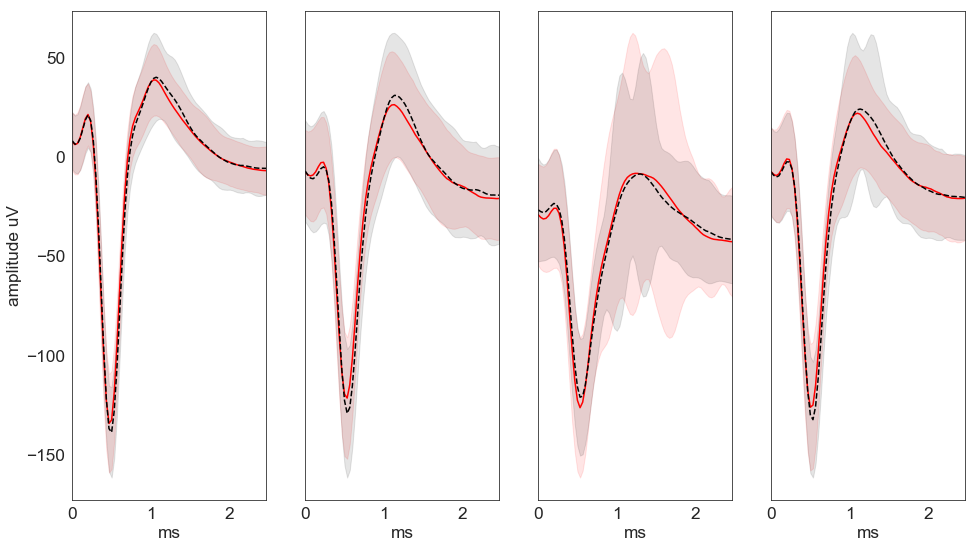

In [15]:
fig, axs = plt.subplots(1, 4)
plot_waveforms(u1, axs=axs, f=np.mean, color='r')
plot_waveforms(u2, axs=axs, f=np.mean, color='k', linestyle='--')

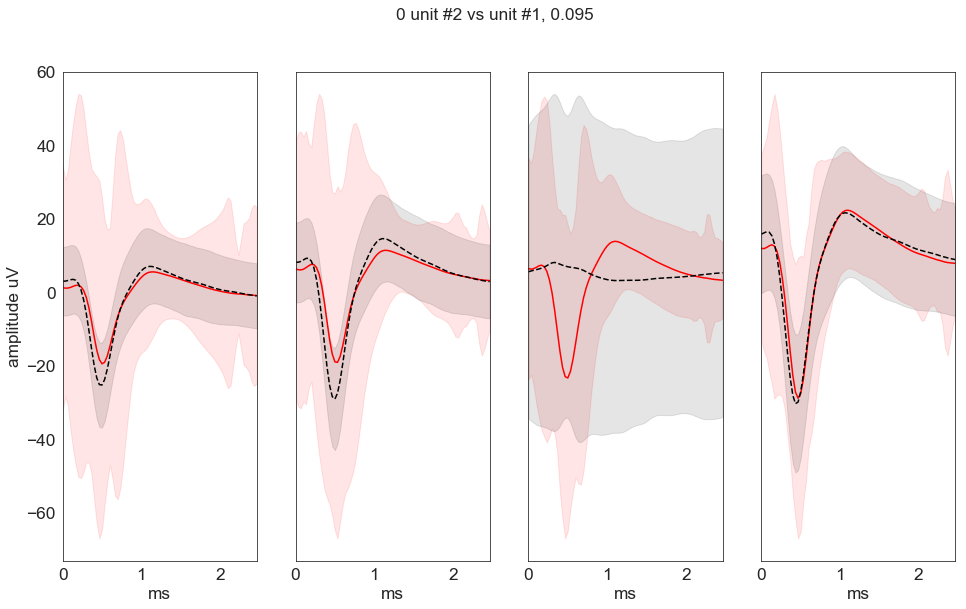

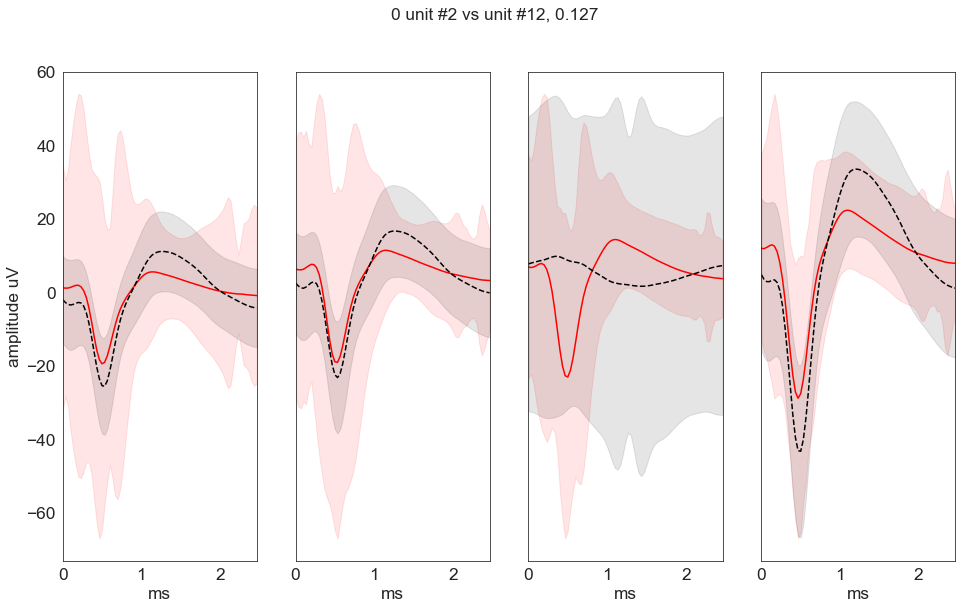

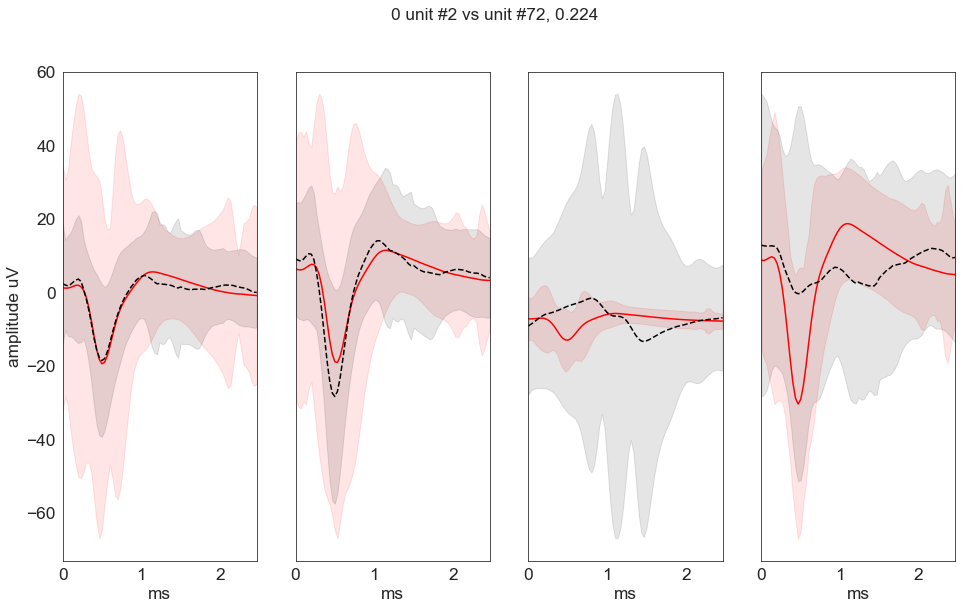

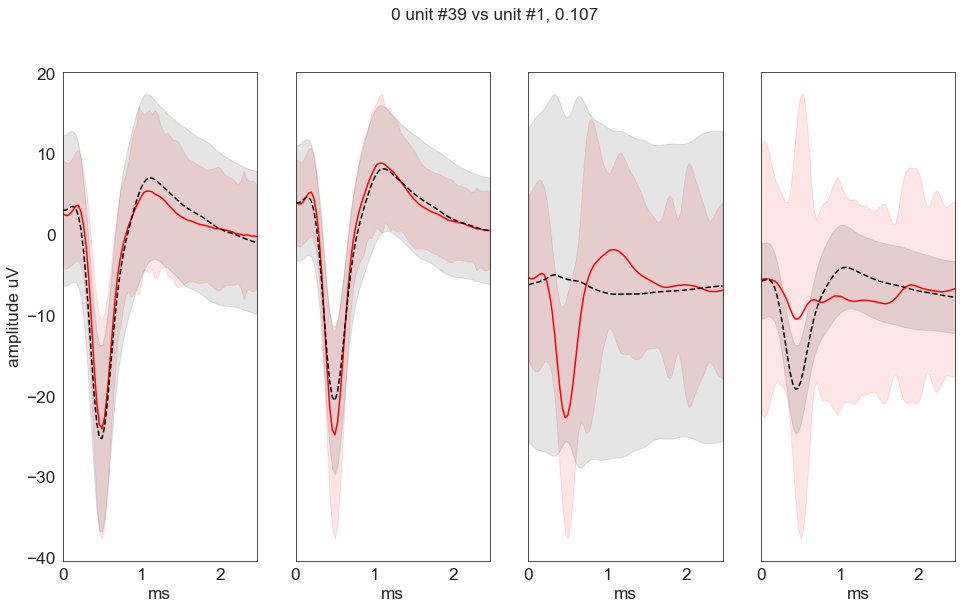

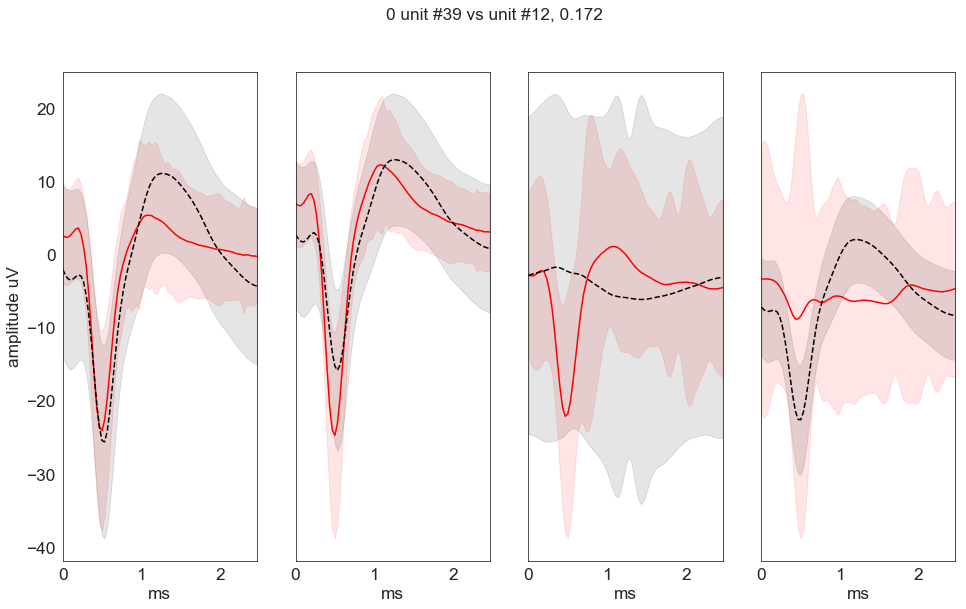

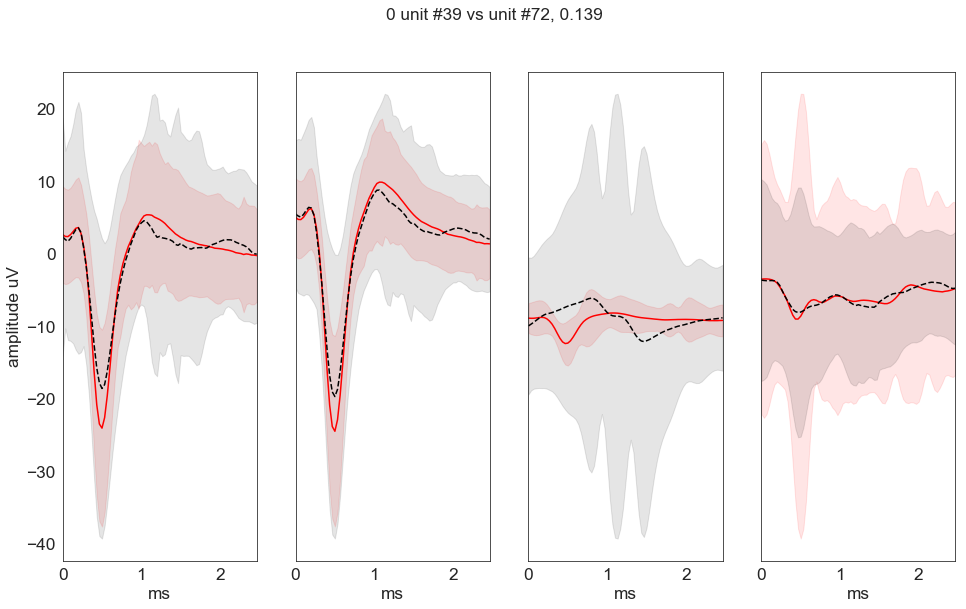

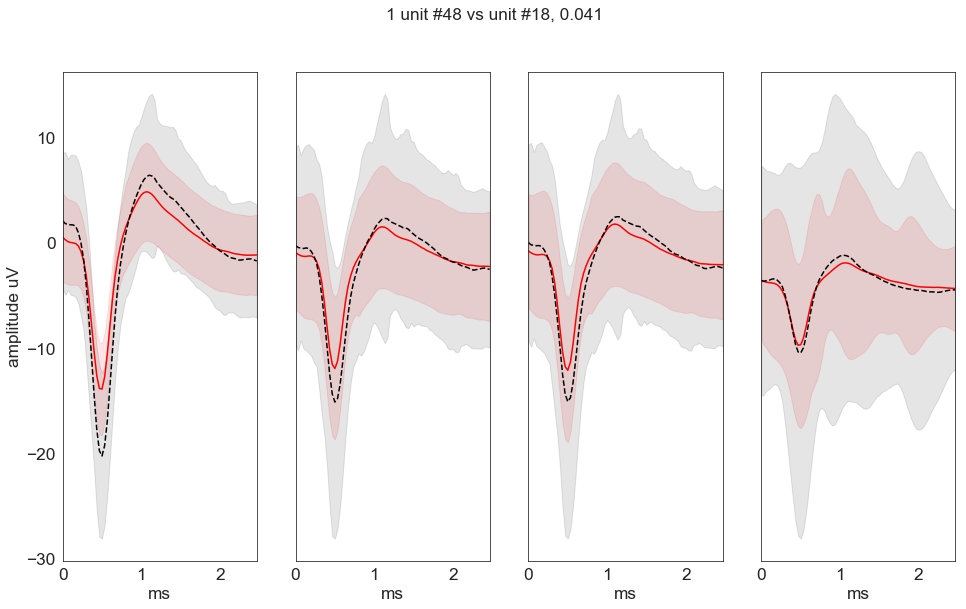

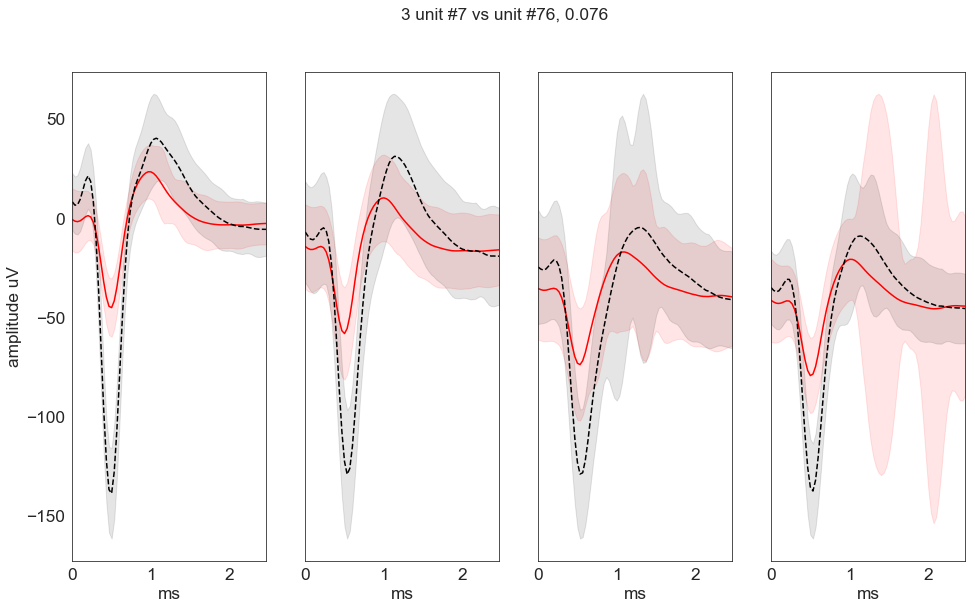

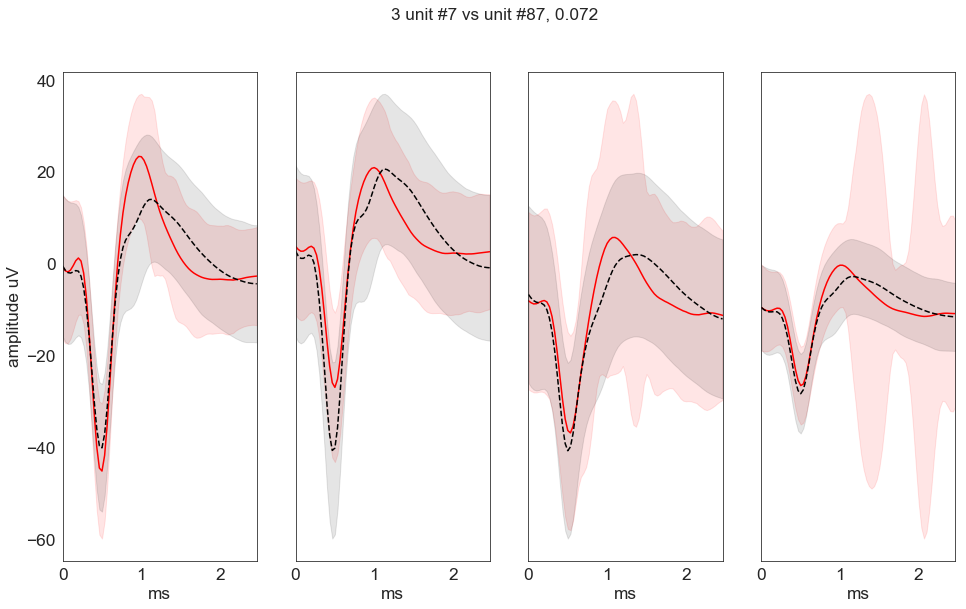

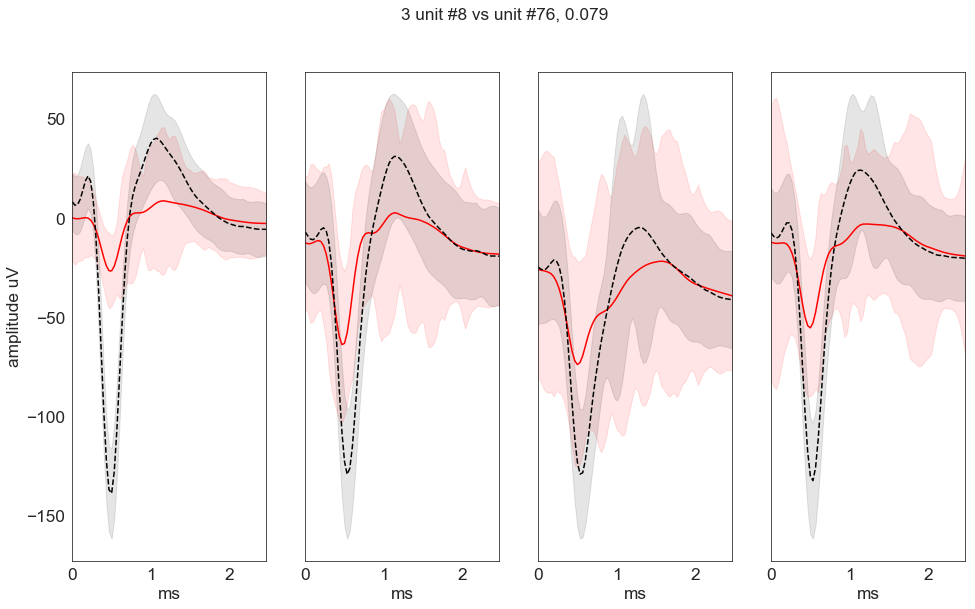

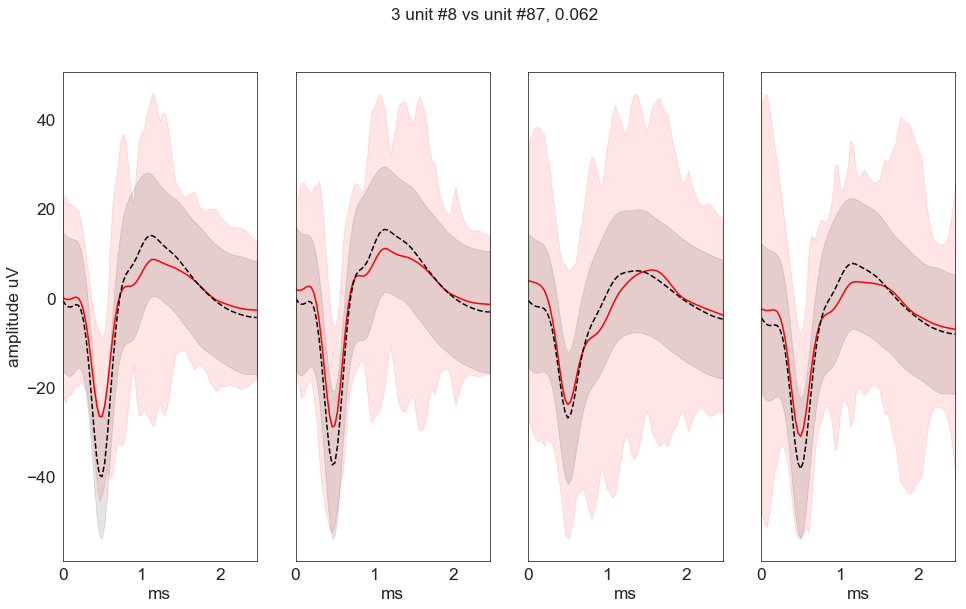

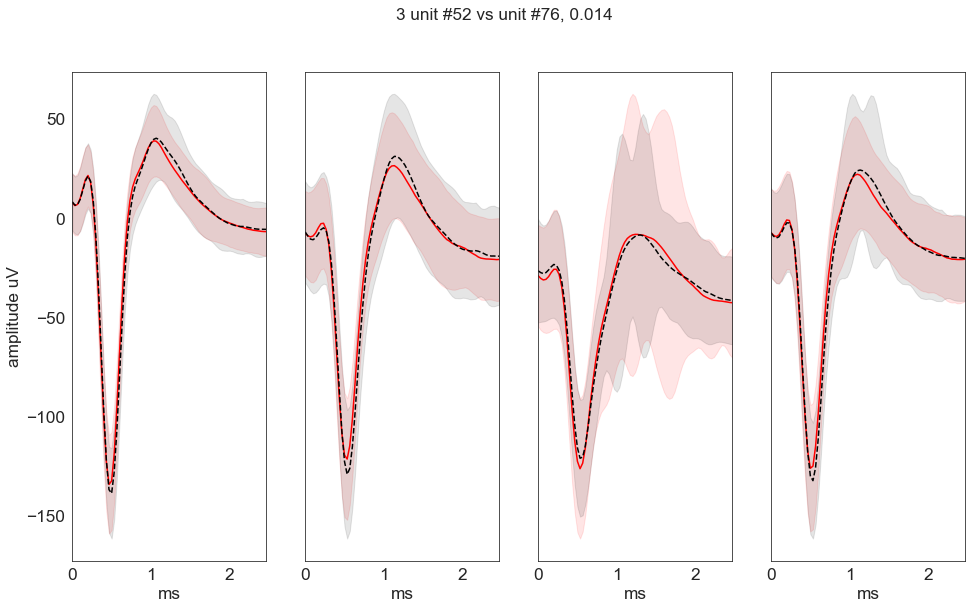

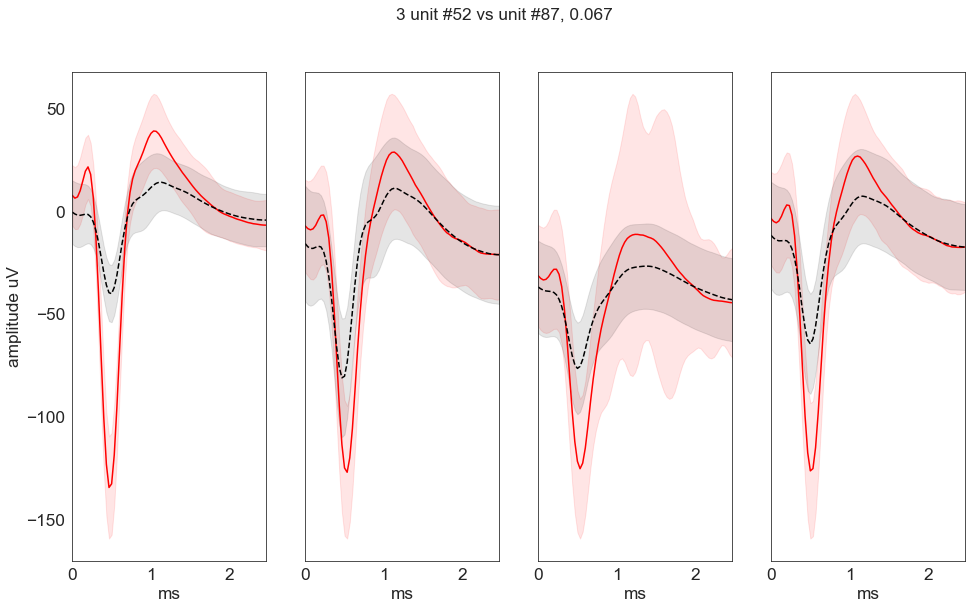

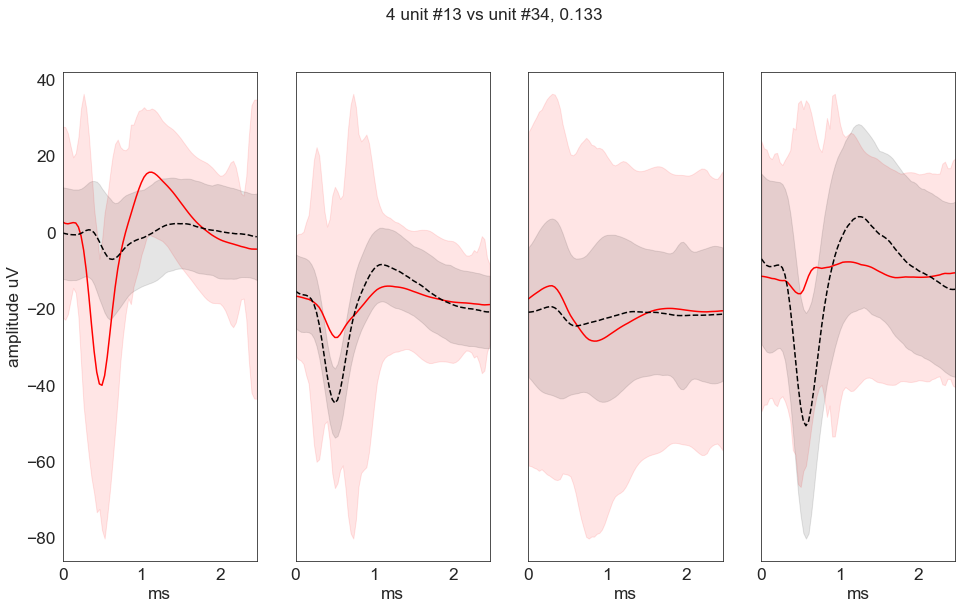

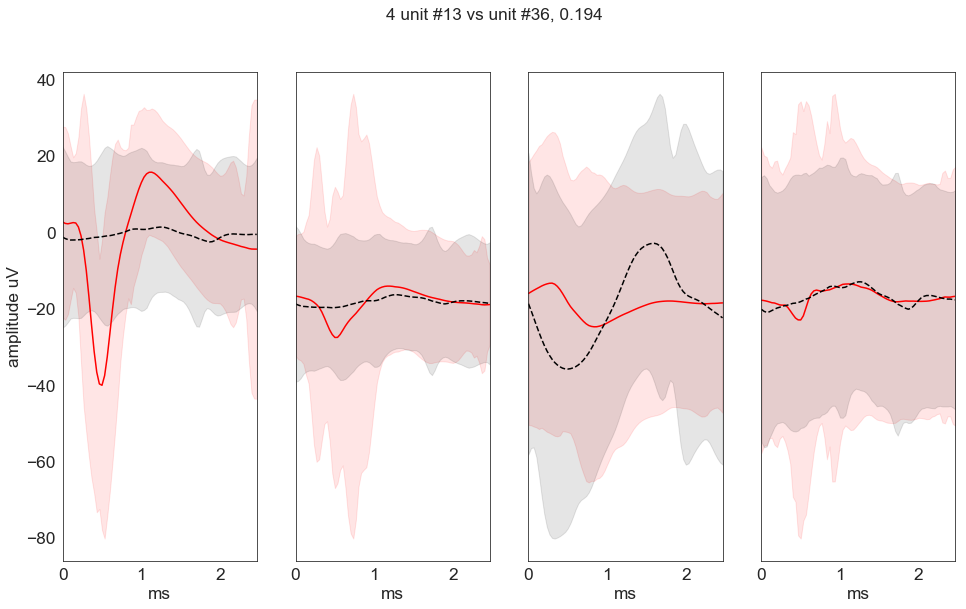

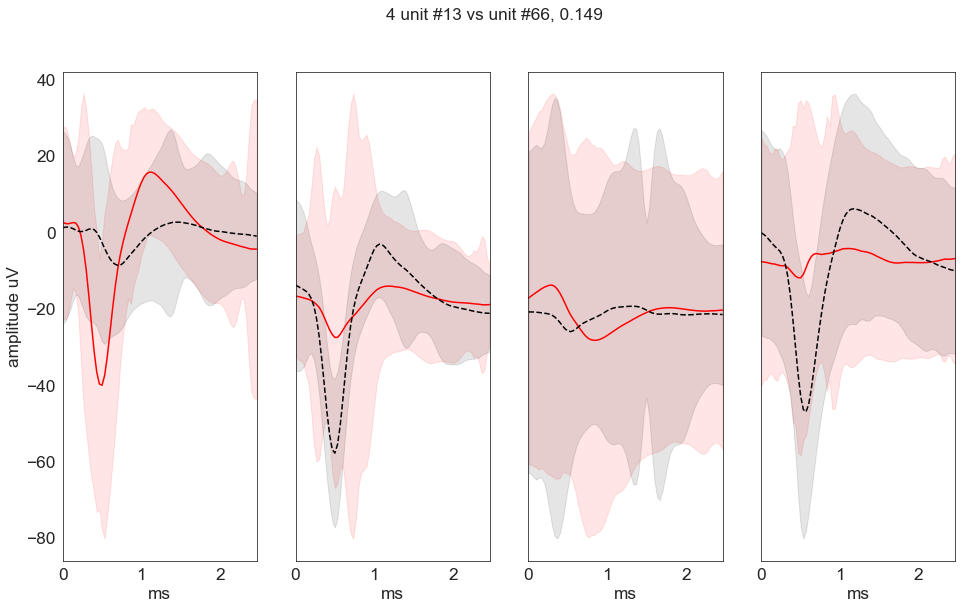

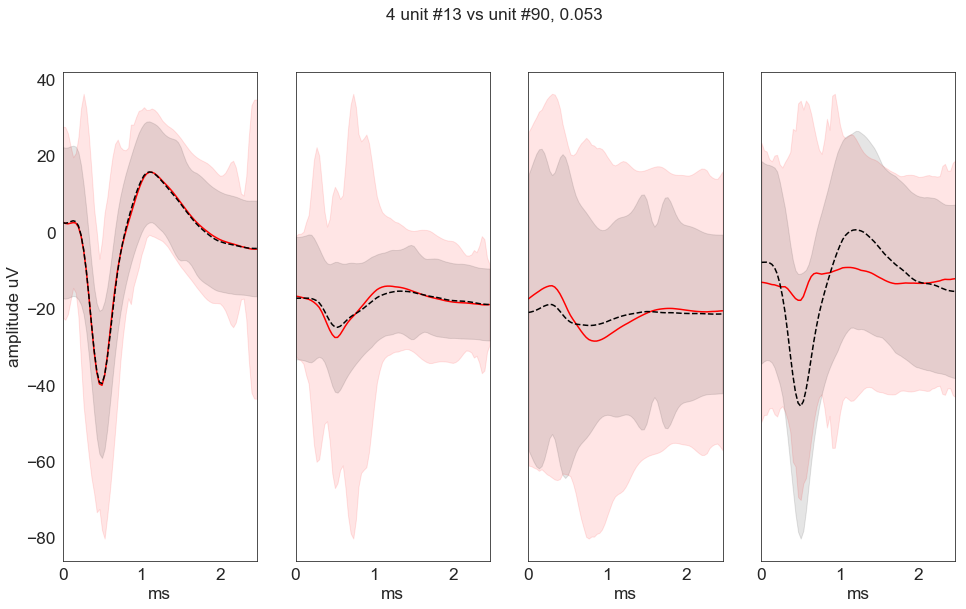

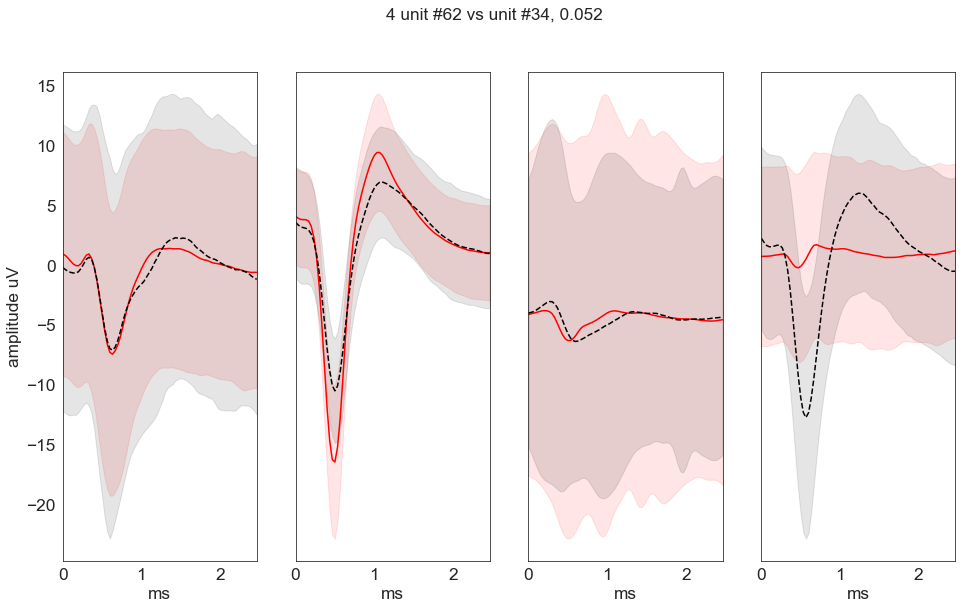

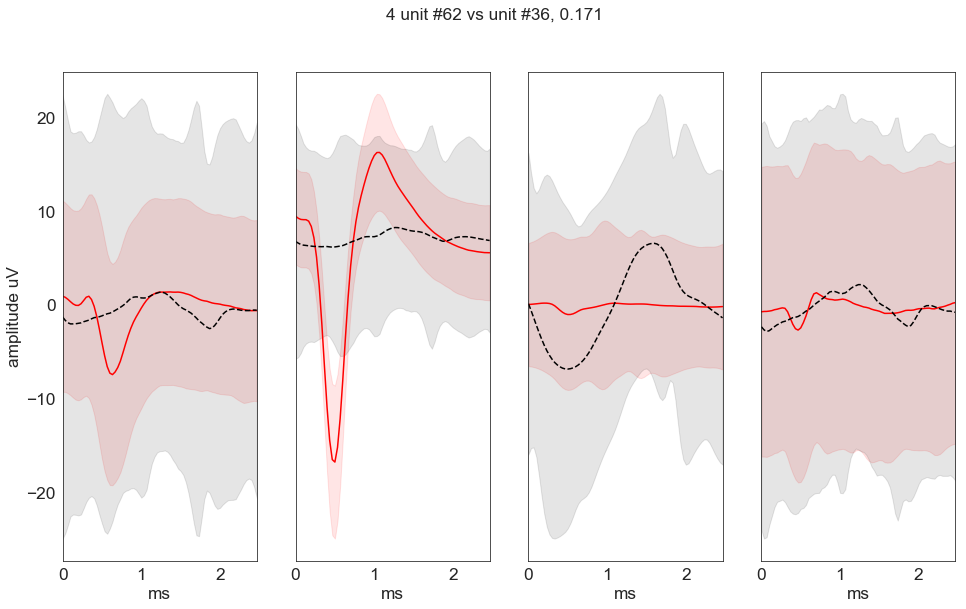

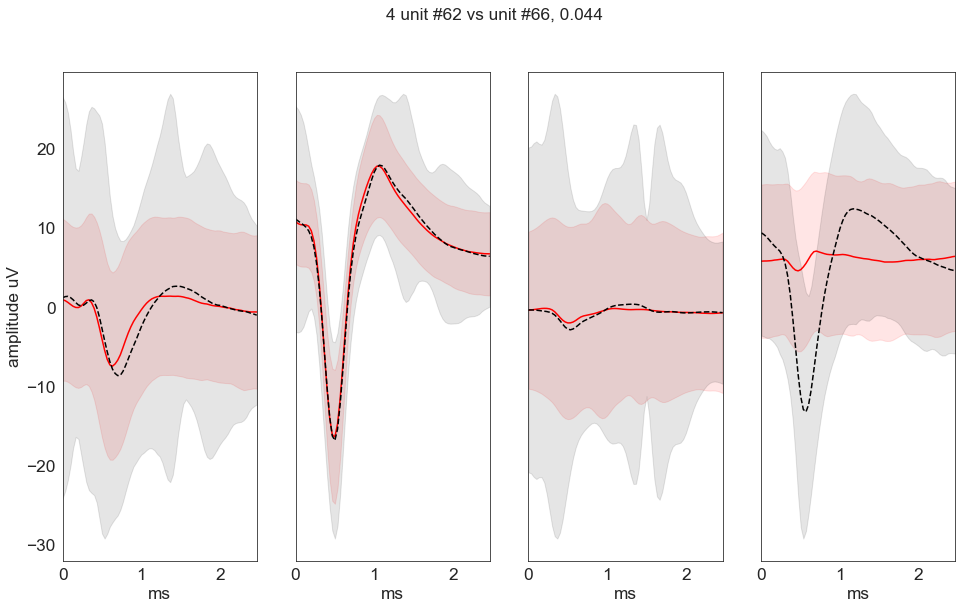

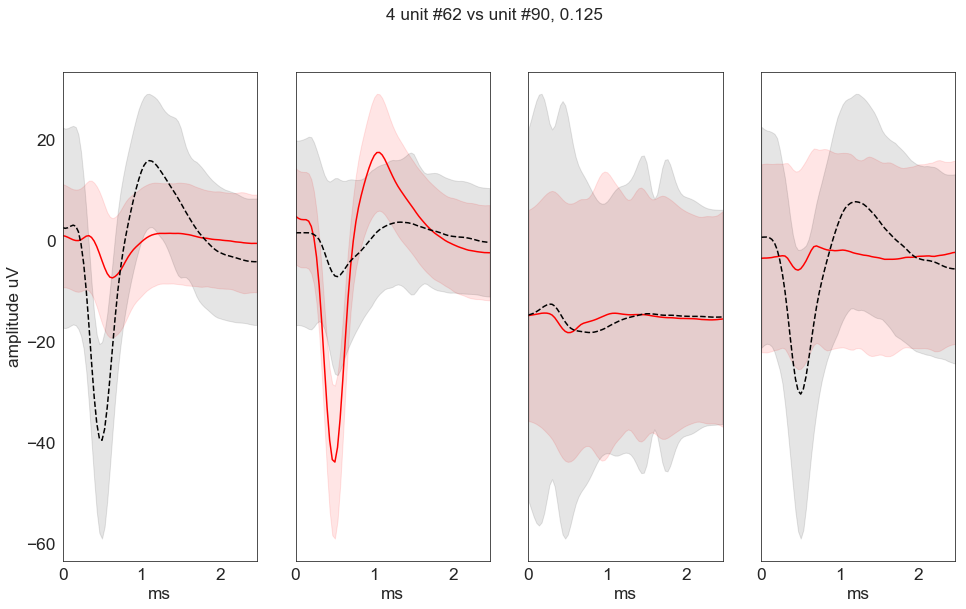

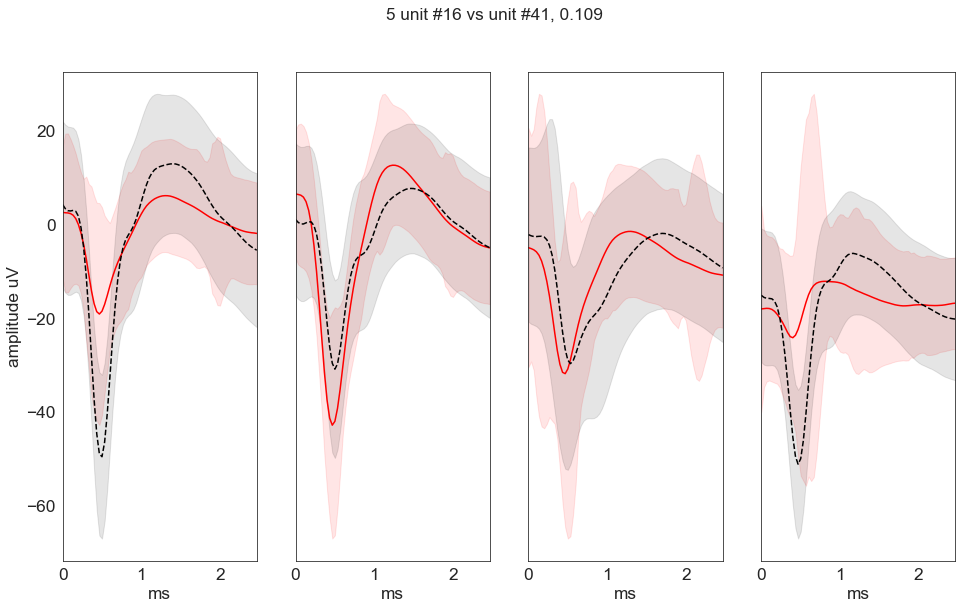

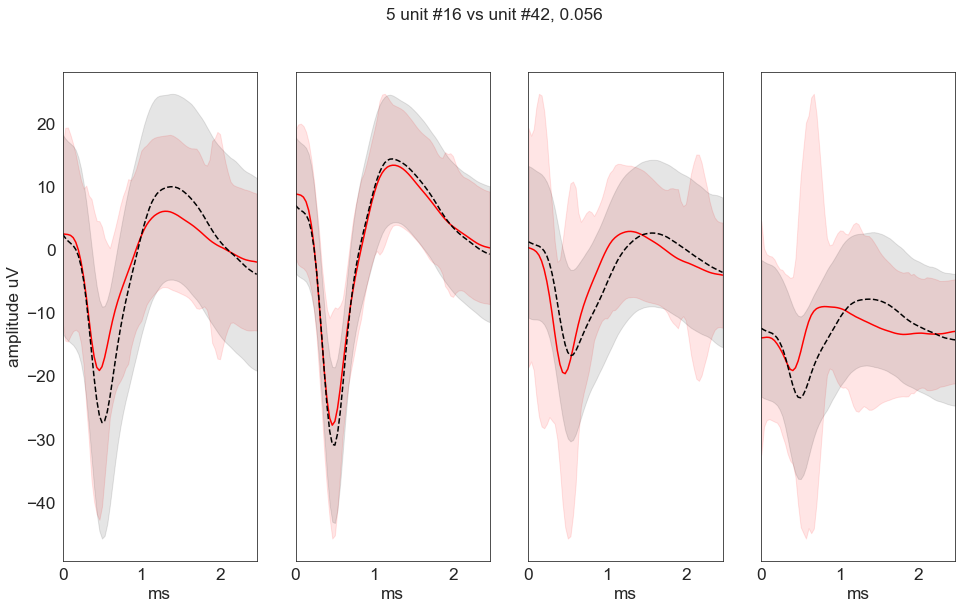

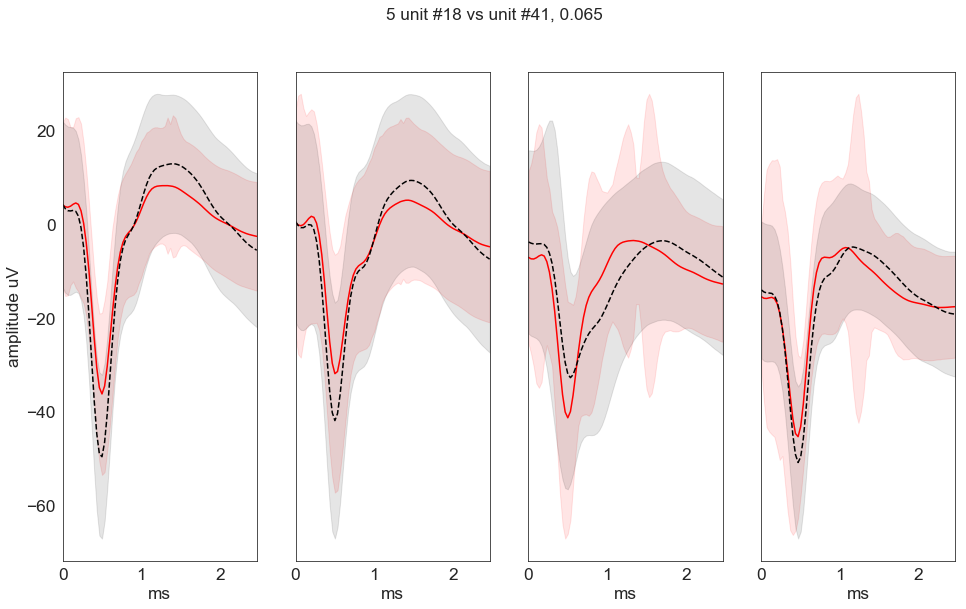

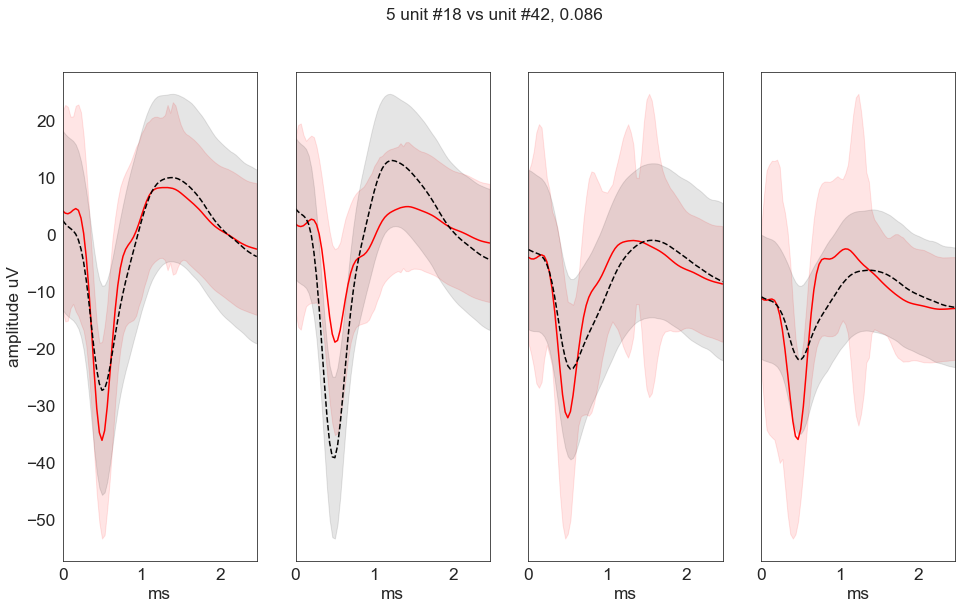

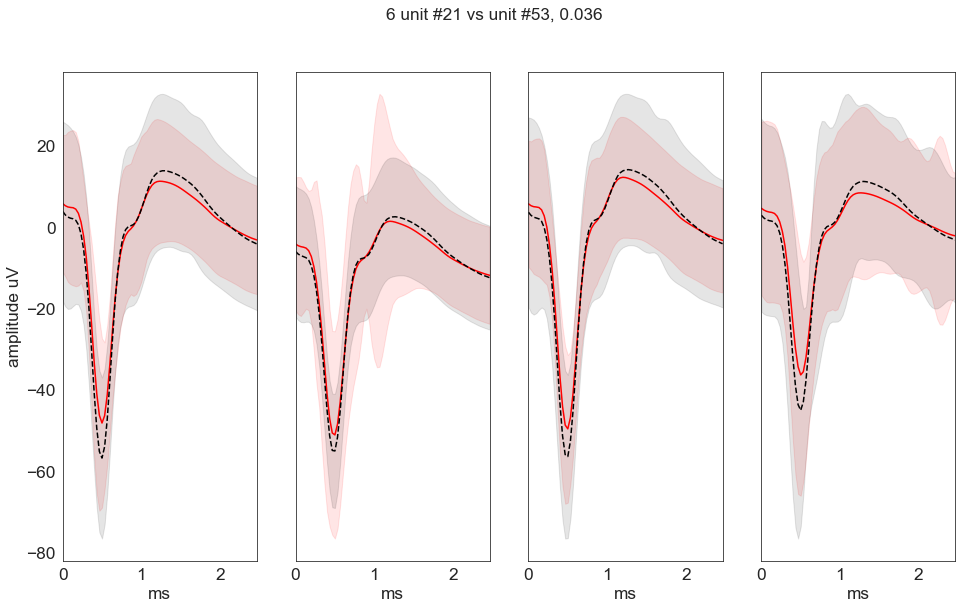

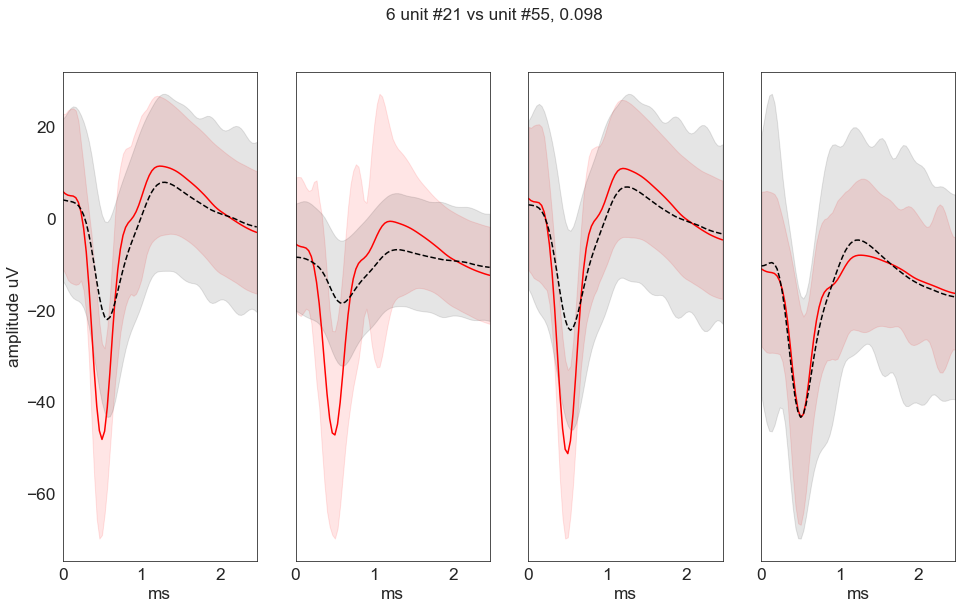

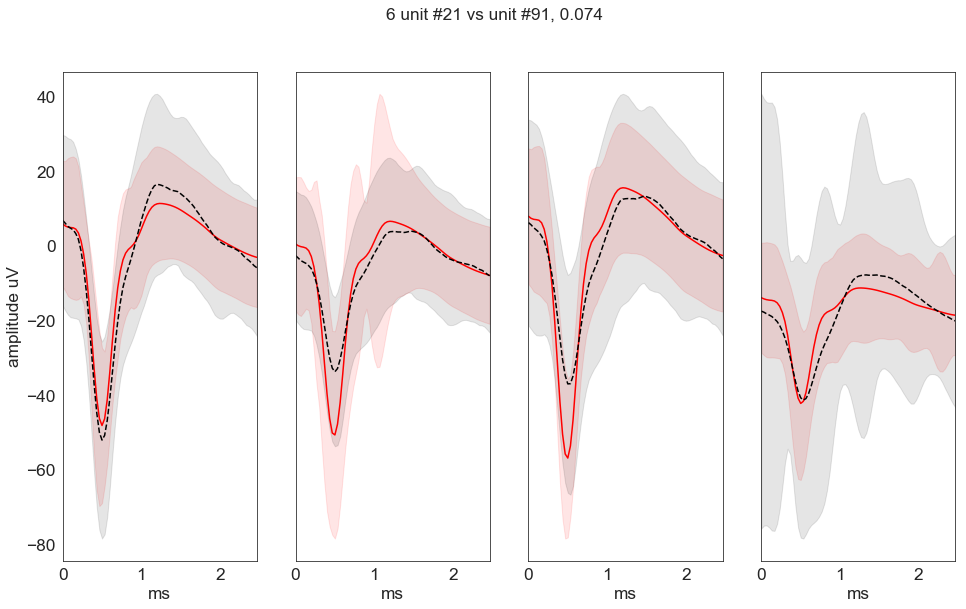

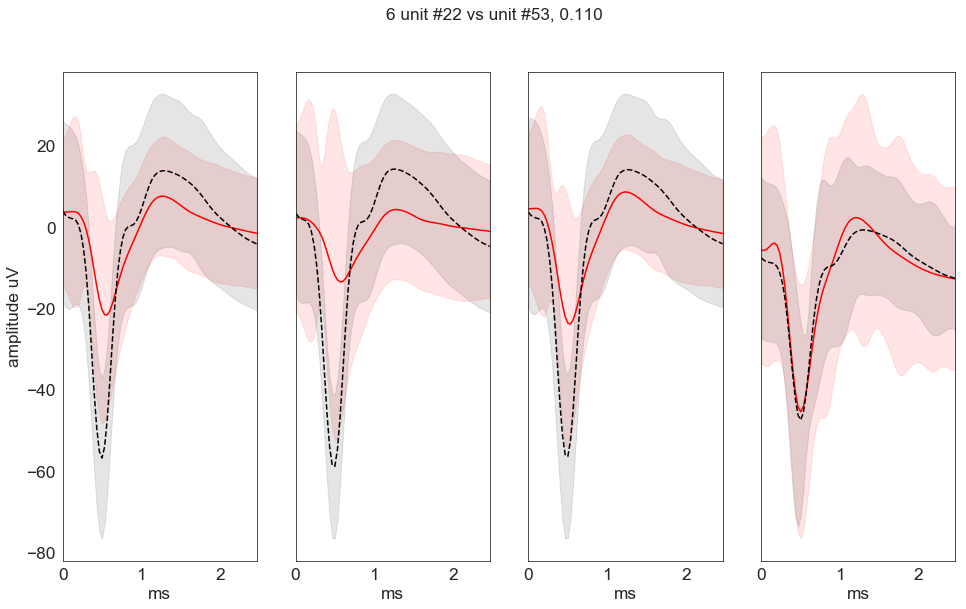

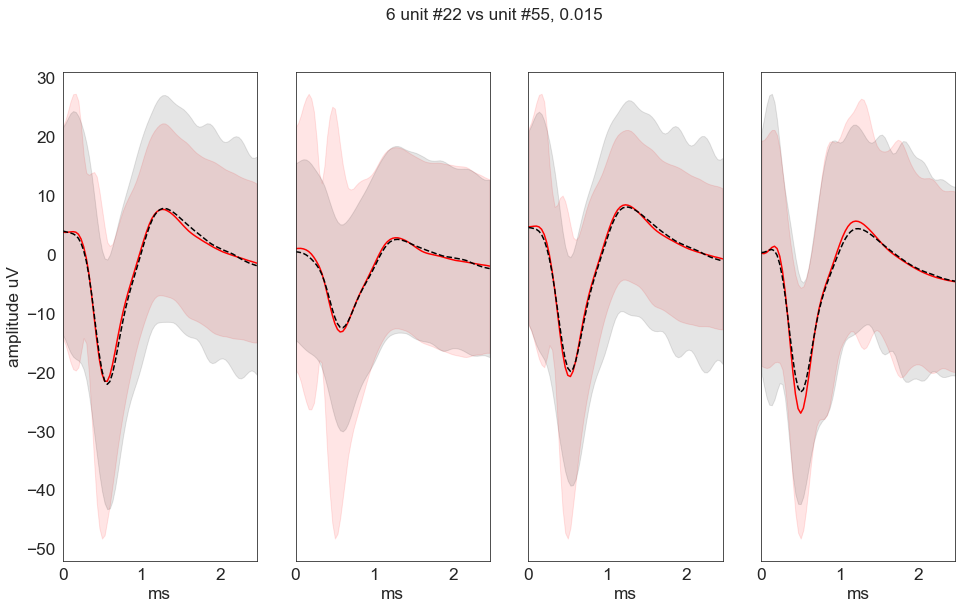

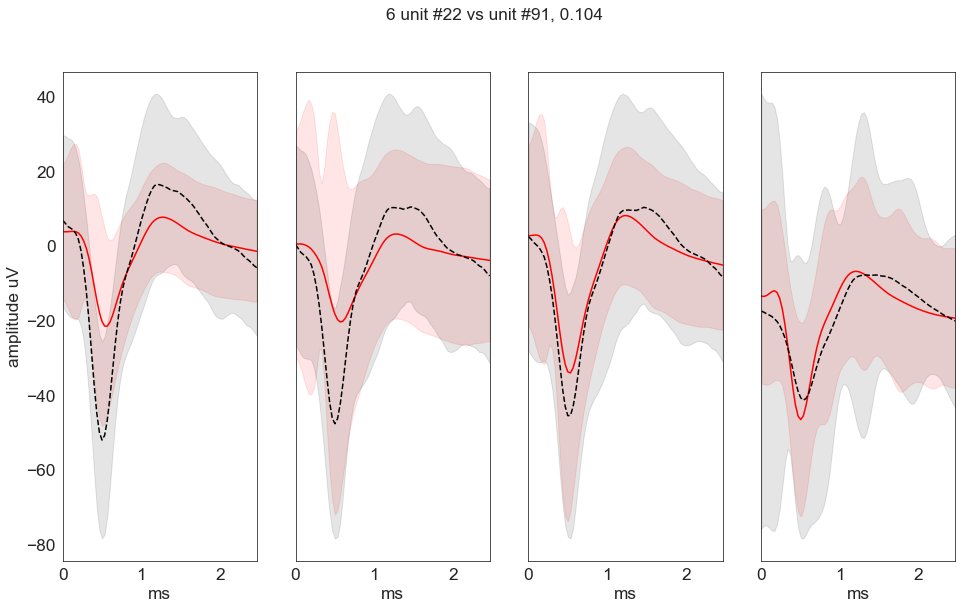

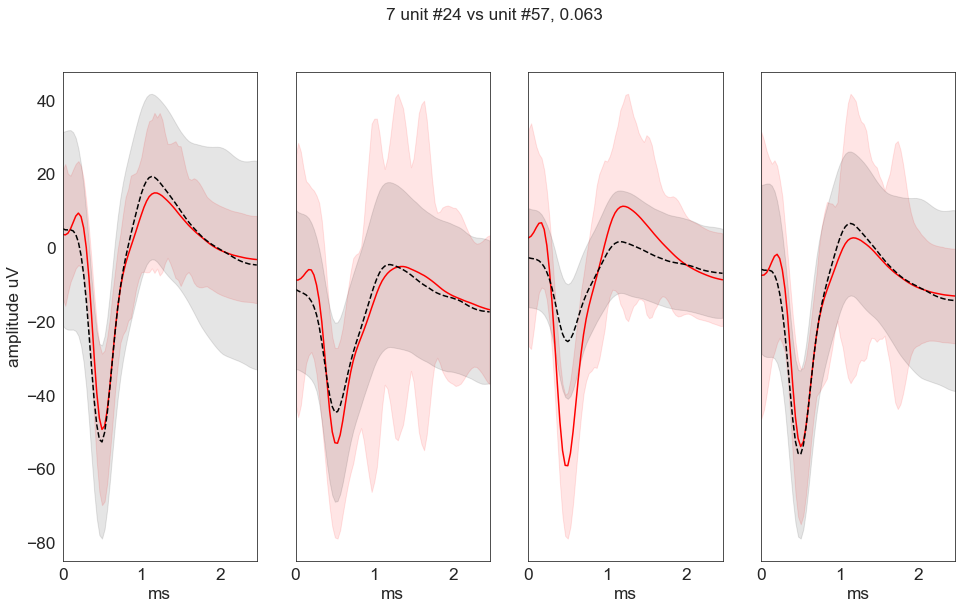

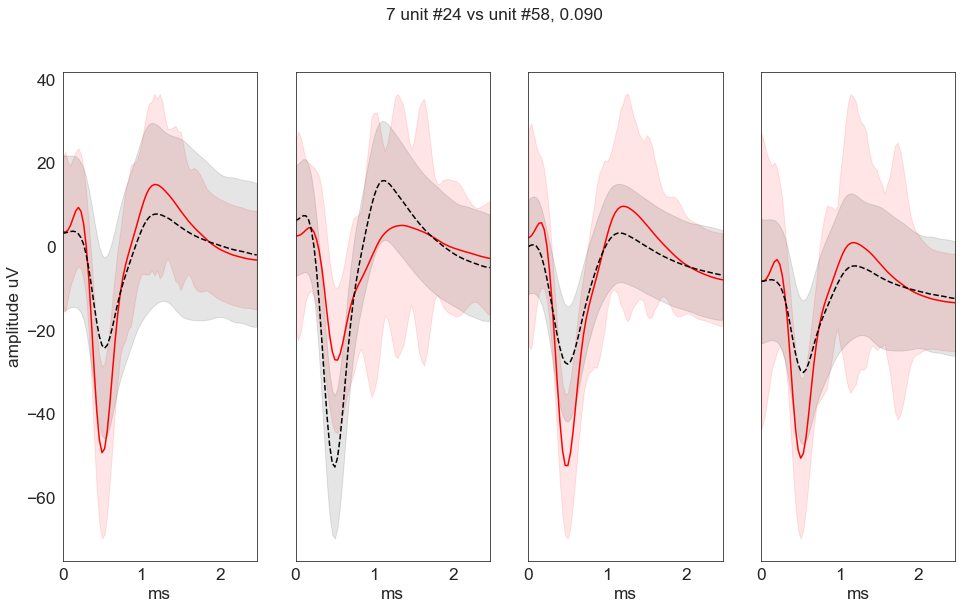

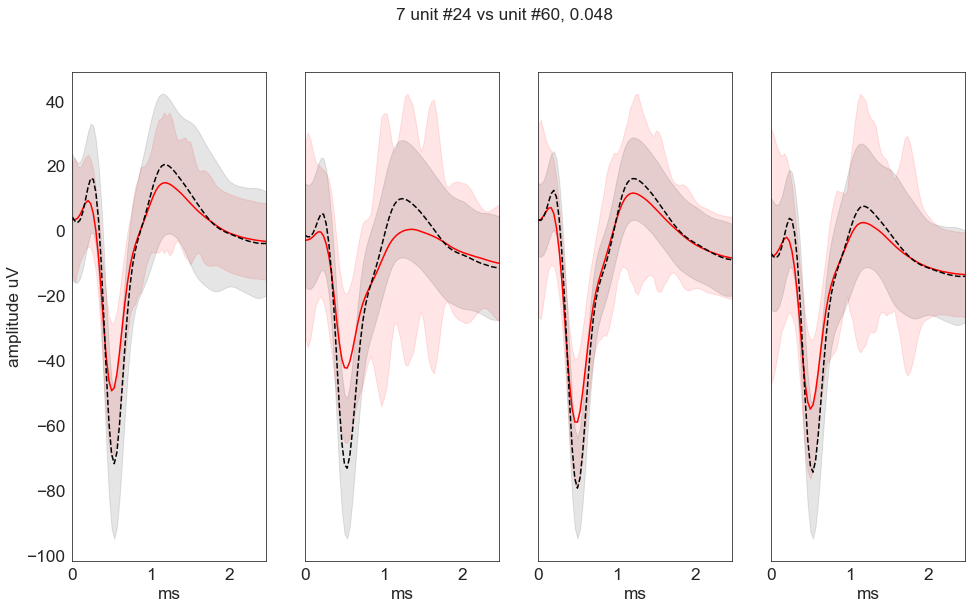

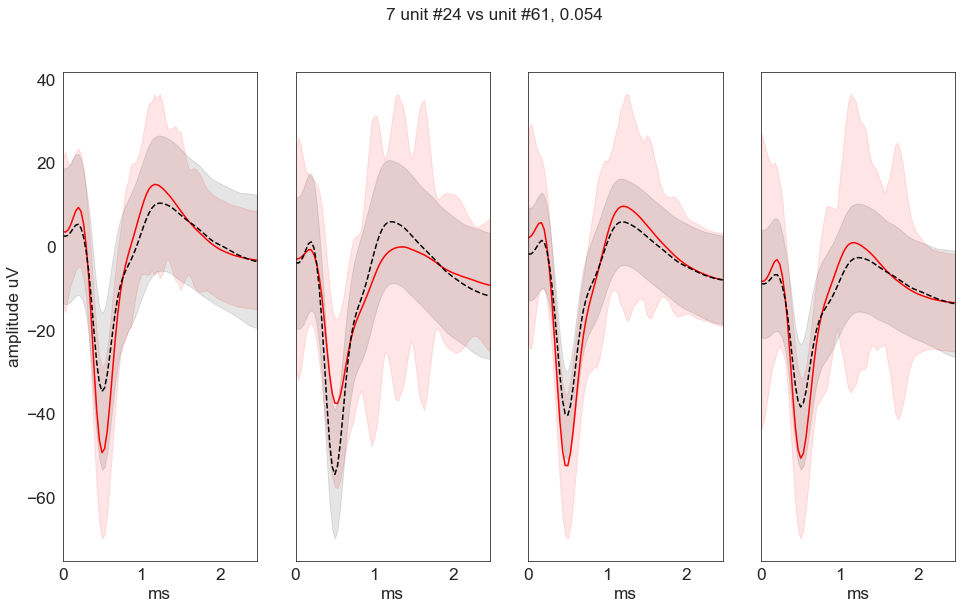

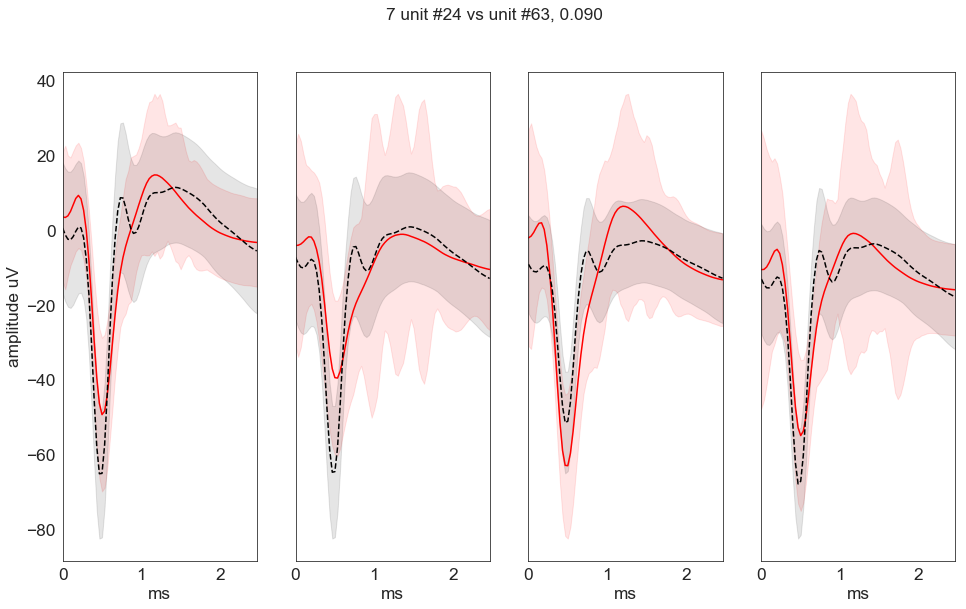

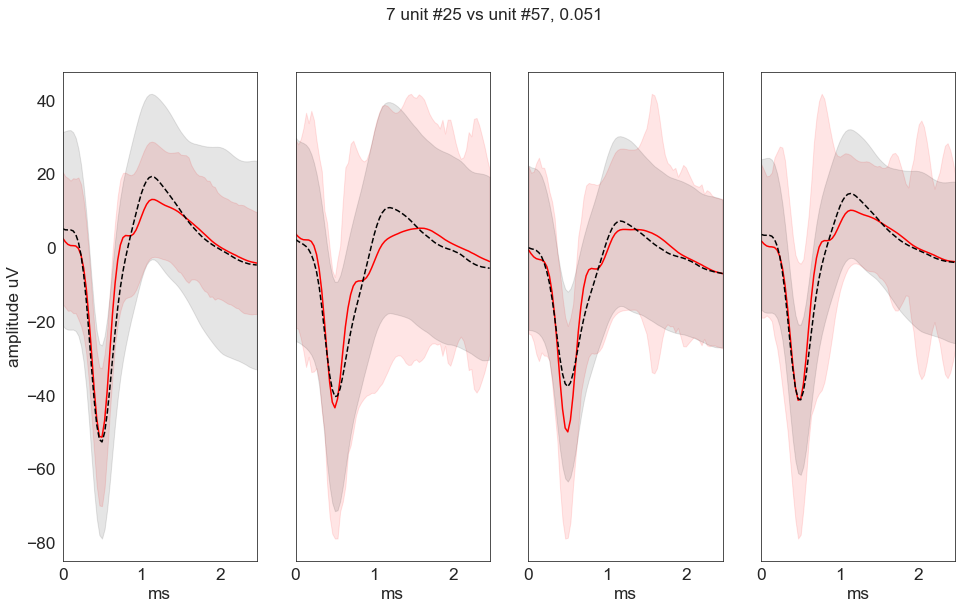

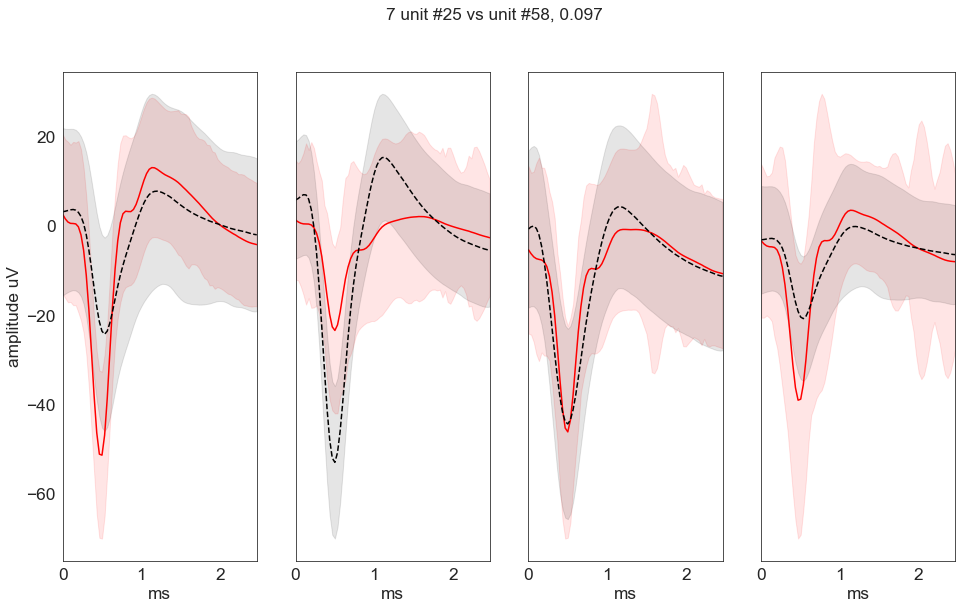

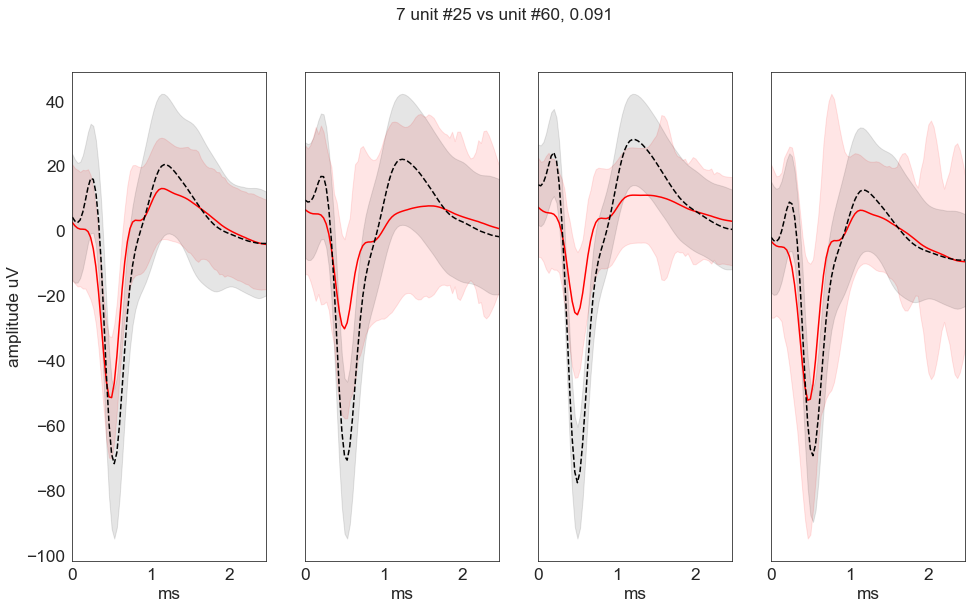

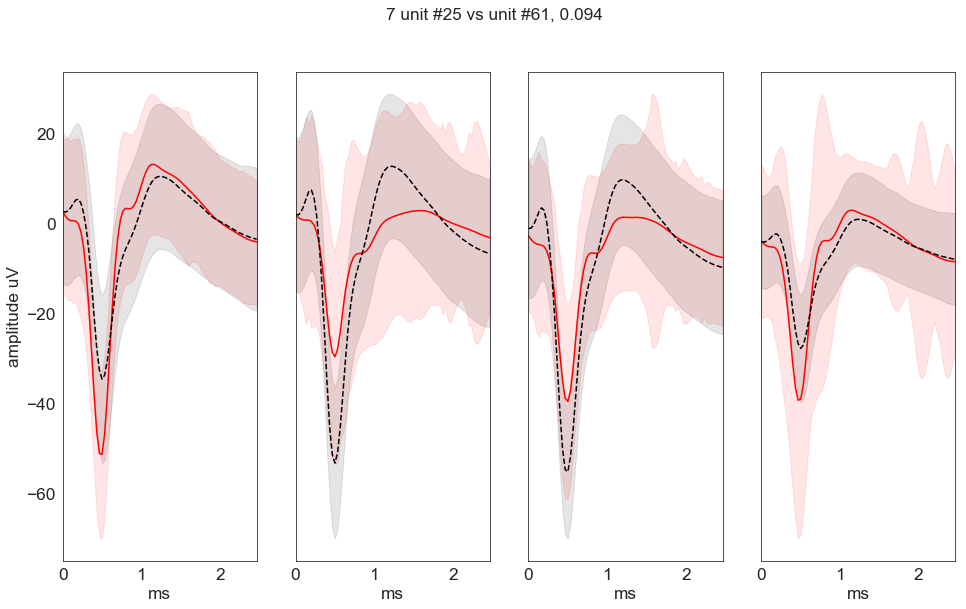

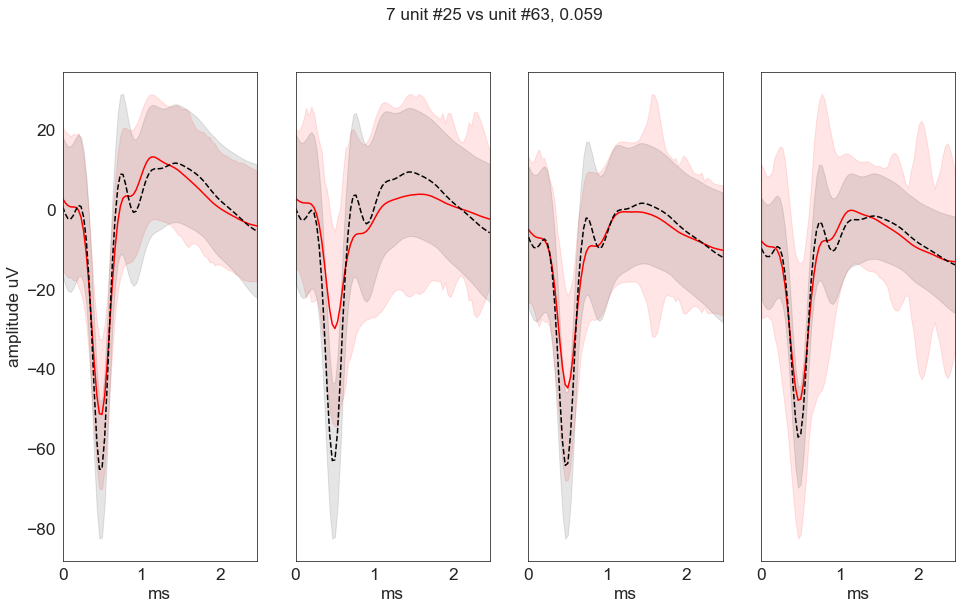

In [13]:
data0, data1 = data[action_ids[0]], data[action_ids[1]]
for (chgrp0, us0), (chgrp1, us1) in zip(data0.items(), data1.items()):
    assert chgrp0 == chgrp1
    for u0 in us0:
        for u1 in us1:
            fig, axs = plt.subplots(1, 4)
            name1 = u0.annotations['name']
            name2 = u1.annotations['name']
            dis = dissimilarity(u1.waveforms, u0.waveforms, np.mean)
            plt.suptitle(f'{chgrp0} {name1} vs {name2}, {dis:.3f}')
            plot_waveforms(u0, axs=axs, f=np.mean, color='r')
            plot_waveforms(u1, axs=axs, f=np.mean, color='k', linestyle='--')

In [16]:
w1 = u1.waveforms.magnitude
w2 = u2.waveforms.magnitude

In [39]:

def my_diff(case, control,  statistic=None):
    return np.mean(np.abs(
        statistic(case, axis=0) / np.max(case) - 
        statistic(control, axis=0) / np.max(control)))


def disimilarity_test(case, control, num_permutations=1000,  statistic=None):
    statistic = statistic or np.mean
    observed_diff = np.mean(np.abs(
        statistic(case, axis=0) / np.max(case) - 
        statistic(control, axis=0) / np.max(control)))
    num_case = case.shape[0]
    combined = np.concatenate([case, control])
    diffs = []
    for i in tqdm(range(num_permutations)):
        xs = np.random.permutation(combined)
        diff = np.abs(
            statistic(xs[:num_case], axis=0) / np.max(xs[:num_case]) - 
            statistic(xs[num_case:], axis=0)  / np.max(xs[num_case:]))
        diffs.append(np.mean(diff))
    pval = np.sum(diffs < observed_diff, axis=0) / float(num_permutations)
    return pval, observed_diff, diffs


In [40]:
ds = []
nrc = w1.shape[1]
for ch in range(nrc):
    d = disimilarity_test(w1[:,ch,:], w2[:,ch,:], statistic=np.mean)
    ds.append(d)

In [41]:
[d[1] for d in ds]

[0.09798557141536683,
 0.01967168129490589,
 0.003102495071299884,
 0.031707806106297254]

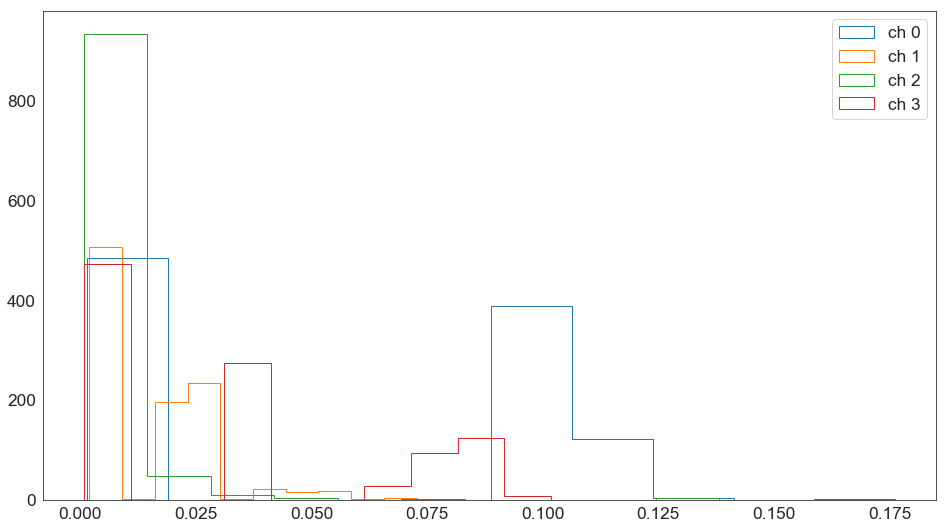

In [42]:
for c, d in enumerate(ds):
    plt.hist(d[2], histtype='step', label=f'ch {c}')
plt.legend()

In [43]:
[d[0] < 0.95 for d in ds]

[True, True, True, True]

In [44]:
ds = []
nrc = w1.shape[1]
for ch in range(nrc):
    d = permutation_resampling(w1[:,ch,:], w2[:,ch,:], func=lambda x, y: my_diff(x, y, np.median))
    ds.append(d)

In [46]:
[d[0] > 0.05 for d in ds]

[True, True, True, True]

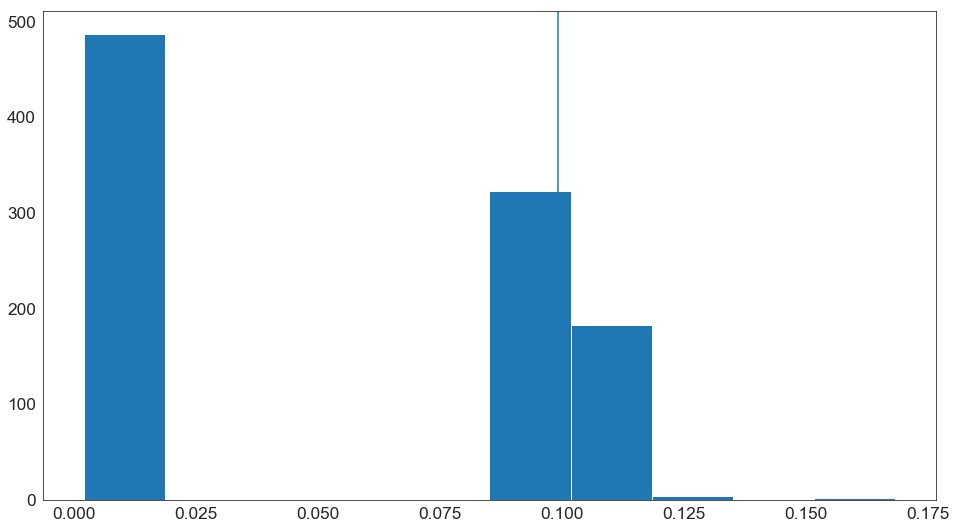

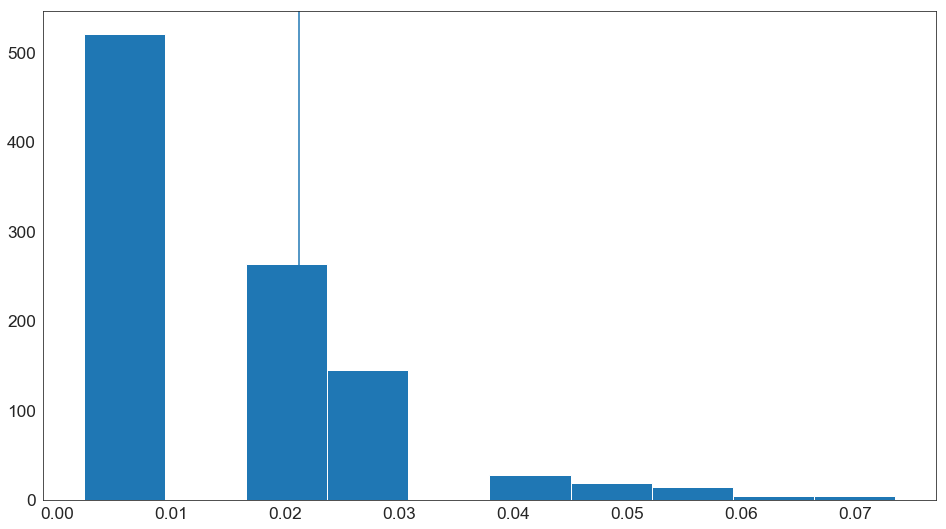

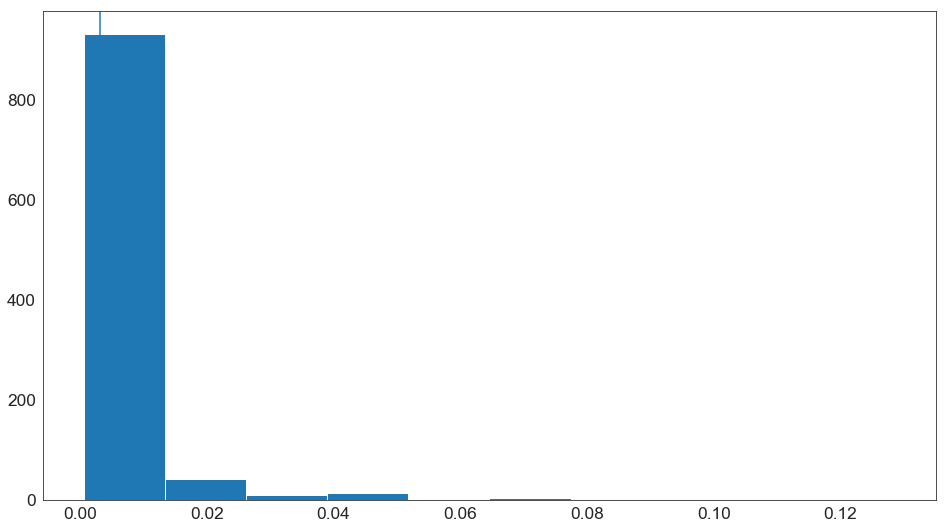

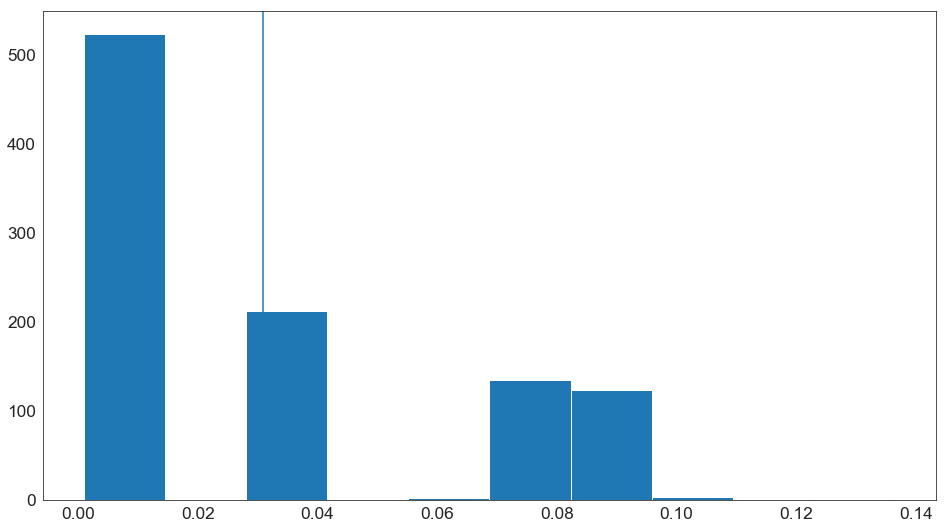

In [48]:
for (p,o,d) in ds:
    plt.figure()
    plt.hist(d)
    plt.axvline(o)

In [26]:
def permutation_resampling(case, control, func, num_permutations=1000):
    observed_diff = func(case, control)
    num_case = case.shape[0]
    combined = np.concatenate([case, control])
    diffs = []
    for i in tqdm(range(num_permutations)):
        xs = np.random.permutation(combined)
        diff = func(xs[:num_case], xs[num_case:])
        diffs.append(diff)
    pval = np.sum(diffs > observed_diff, axis=0) / float(num_permutations)
    return pval, observed_diff, diffs

In [36]:
p, o, d = permutation_resampling(w1, w2, func=lambda x, y: dissimilarity(x, y, np.median))

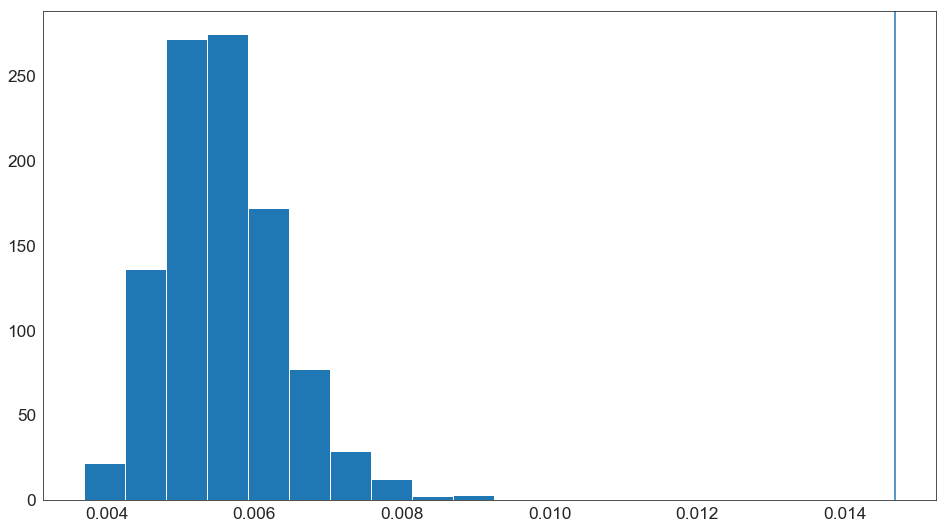

In [37]:
plt.hist(d)
plt.axvline(o)

In [38]:
p

0.0